## 07-03 Similarity-based Link Prediction

*June 12 2024*  

We now use measures for the similarity of nodes to address the task of link prediction in an empirical network. We test all the different similarity scores introduced in the lecture and evaluate their predictive performance in terms of the AUC (in a single training-test split of the network).

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import linalg as spl
import scipy as sp

from sklearn import metrics
from matplotlib import pyplot as plt

import seaborn as sns 

import pathpy as pp

plt.style.use('default')
sns.set_style("whitegrid")

ModuleNotFoundError: No module named 'node2vec'

We first load an empirical network from the `netzschleuder` repository.

In [37]:
n = pp.io.graphtool.read_netzschleuder_network('student_cooperation')
print(n)

[06-15 10:38:37: WARNING] 49 edges existed already and were not be considered. To capture those edges, consider creating a multiedge and/or directed network.


Uid:			0x2df64ed6c70
Type:			Network
Directed:		False
Multi-Edges:		False
Number of nodes:	185
Number of edges:	311

Network attributes
------------------
name:	student_cooperation
description:	Network of cooperation among students in the "Computer and Network Security" course at Ben-Gurion University, in 2012. Nodes are students, and edges denote cooperation between students while doing their homework. The graph contains three types of links: Time, Computer, Partners.[^icon]
[^icon]: Description obtained from the [ICON](https://icon.colorado.edu) project.
citation:	[['M. Fire et al., "Predicting student exam\'s scores by analyzing social network data." International Conference on Active Media Technology, 584-595 (AMT 2012)', 'https://doi.org/10.1007/978-3-642-35236-2_59']]
url:	https://homes.cs.washington.edu/~fire/#section3
tags:	['Social', 'Offline', 'Multigraph', 'Unweighted']
title:	Student cooperation (2012)
bibtex:	["@incollection{fire_predicting_2012,\n  doi          = {10.1007

We split the set of edges in the network into a training and test set, where the split is performed along the edges and the test set contains 25 % of all edges. We will use the training set to calculate node similarities and then use those similarities to predict links in the test set.

The `train_test_split` function in `pathpy`'s evaluation model returns to network instances that have the same set of nodes but different edge sets.

In [38]:
train, test = pp.algorithms.evaluation.train_test_split(n, test_size = 0.25, split='edge')

In [39]:
print(train)
print(test)

Uid:			0x2df64ed6c70_train
Type:			Network
Directed:		False
Multi-Edges:		False
Number of nodes:	185
Number of edges:	234
Uid:			0x2df64ed6c70_test
Type:			Network
Directed:		False
Multi-Edges:		False
Number of nodes:	185
Number of edges:	77


To simplify the prediction and the evaluation, we first create a `pandas` data frame that will contain node pairs, the ground truth (i.e. whether a link exists or not in the test set) as well as the similarity scores between nodes. Let's start with the edges in the test set, i.e. the positive instances of our classification problem:

In [40]:
test_set = pd.DataFrame([ (e.v.uid, e.w.uid, 1) for e in test.edges ], columns=['v', 'w', 'link'])
print(test_set)

      v    w  link
0   134  170     1
1   128  116     1
2    28   31     1
3     7   10     1
4    89   92     1
..  ...  ...   ...
72   86   88     1
73  103   60     1
74   95   94     1
75  179   44     1
76   69   67     1

[77 rows x 3 columns]


To obtain a balanced binary classification problem, we generate a set of random negative samples, i.e. node pairs that are neither connected in the training nor in the test set. We sample the same number of negative samples as we have edges in the test set and add those samples to the test data frame. We obtain a balanced data set, which allows us to cast the problem as a binary classification problem. 

In [41]:
nodes = [v.uid for v in test.nodes]
num = 0
negative = []

# add same number of negative instances as positive instances
while num<test.number_of_edges():
    v, w = np.random.choice(nodes, 2, replace=False)

    # make sure that nodes are neither connected in training nor in test network
    if (v, w) not in test.edges and (v, w) not in train.edges:
        # add node pair with ground truth (link) zero
        negative.append((v, w, 0))
        num += 1
negative = pd.DataFrame(negative, columns=['v', 'w', 'link'])

# add to test set
test_set = pd.concat([negative, test_set], ignore_index=True)
test_set.reset_index()
print(test_set)

       v    w  link
0     20   42     0
1    126   55     0
2    118   35     0
3    175  179     0
4    145   90     0
..   ...  ...   ...
149   86   88     1
150  103   60     1
151   95   94     1
152  179   44     1
153   69   67     1

[154 rows x 3 columns]


We will now calculate a similarity score for all node pairs in the test set, rank nodes by similarity and use the `sklearn` function `sklearn.metrics.roc_curve` to calculate a ROC curve and an AUC score based on the similarity scores.

Let's start by defining a function that returns (dummy) node similarities for node pairs. We implement another function that assigns those scores to all node pairs in the test set, adding a column `sim` to the data frame:

In [44]:
def random_sim(network, v, w, **kwargs):
    return np.random.ranf()

def assign_sim(network, test_df, similarity_score, **kwargs):
    sim = []
    for index, row in test_df.iterrows():
        sim.append(similarity_score(network, row['v'], row['w'], **kwargs))
    test_df['sim'] = sim

In [45]:
assign_sim(train, test_set, node_sim)
print(test_set)

       v    w  link       sim
0     20   42     0  0.885805
1    126   55     0  0.079625
2    118   35     0  0.732863
3    175  179     0  0.754609
4    145   90     0  0.792658
..   ...  ...   ...       ...
149   86   88     1  0.319462
150  103   60     1  0.507961
151   95   94     1  0.297568
152  179   44     1  0.092973
153   69   67     1  0.259988

[154 rows x 4 columns]


Using the similarity scores of node pairs, we can use the  [`sklearn.metrics.roc_curve` function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) to compute a Receiver-Operator-Characteristic. This function returns the false positive and the true positive rates for a range of discrimination thresholds. We use the false and true positive rates to plot the ROC curve and we use ['sklearn.metrics.auc']() to calculate the Area Under Curve of our classifier.

In [46]:
def compute_ROC(test_set):
    fpr, tpr, thresholds = metrics.roc_curve(test_set['link'].values, test_set['sim'].values)
    plt.plot(fpr, tpr)
    plt.plot(np.linspace(0,1), np.linspace(0,1), ls='--', c='r', alpha=0.5)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    print('AUC =', metrics.auc(fpr, tpr))

Naturally, since we used random similarity scores, the resulting link prediction classifier does not have predictive power, so we get an AUC score of approx. $0.5$.

AUC = 0.4972170686456401


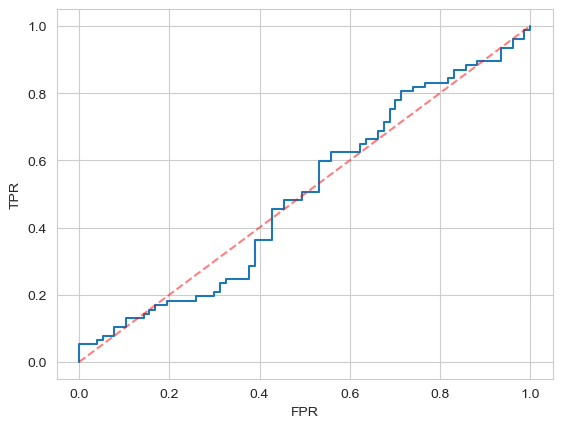

In [47]:
compute_ROC(test_set)

## Testing Meaningful Node Similarity Scores

We now use meaningful similarity scores introduced in the lecture. We start with the inverse of the shortest path length between two nodes, i.e. the larger the value the higher the similarity:

In [48]:
def inverse_path_length(n, v, w, **kwargs):
    dist, _ = pp.algorithms.single_source_shortest_paths(n, v)
    return 1/dist[n.nodes.index[w]]

In [49]:
assign_sim(train, test_set, inverse_path_length)

AUC = 0.7405970652723899


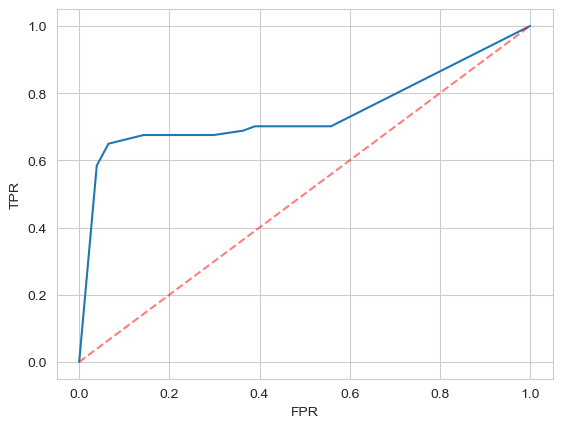

In [50]:
compute_ROC(test_set)

That's not too bad for the start. Let's test the common neighbors score:

In [51]:
def common_neighbors(n, v, w, **kwargs):
    N_v = n.successors[v]
    N_w = n.successors[w]
    return len(N_v.intersection(N_w))

AUC = 0.7772811603980434


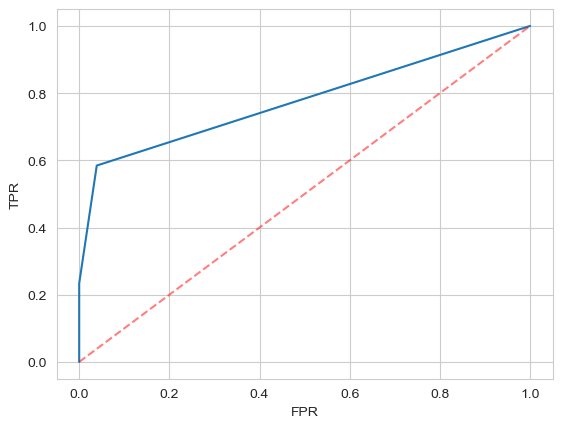

In [52]:
assign_sim(train, test_set, common_neighbors)
compute_ROC(test_set)


Let us now try the Jaccard index of the nodes' neighbors. Different from the common definition, we define the Jaccard index of two empty sets as zero.

In [54]:
def jaccard_similarity(n, v, w):
    N_v = n.successors[v]
    N_w = n.successors[w]
    intersection = N_v.intersection(N_w)
    if len(N_v) == 0 and len(N_w) == 0:
        return 1
    else:
        return len(intersection)/(len(N_v) + len(N_w) - len(intersection))

AUC = 0.7998819362455725


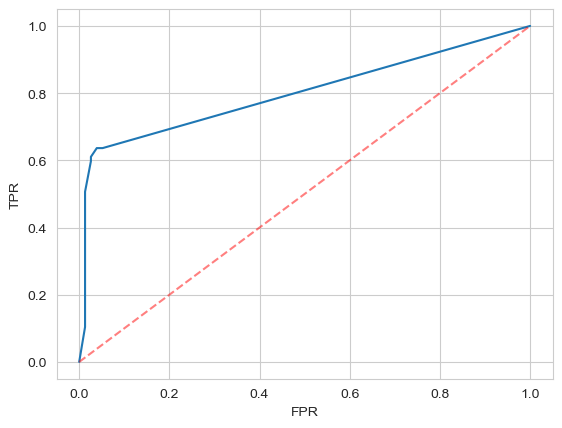

In [55]:
assign_sim(train, test_set, jaccard_similarity)
compute_ROC(test_set)

The Szymkiewicz-Simpson (or Overlap) coefficient normalizes the number of common neighbor based on the smaller degree of the two nodes, which allows us to account for nodes with overlapping neighbor sets. Here we account for the case that one of the two nodes has zero degree, in which case we return a similarity of zero.

In [60]:
def overlap_coefficient(n, v, w):
    N_v = n.successors[v]
    N_w = n.successors[w]
    if len(N_v) == 0 or len(N_w) == 0:
        return 0
    else:
        return len(N_v.intersection(N_w))/min(len(N_v), len(N_w))

AUC = 0.7831000168662505


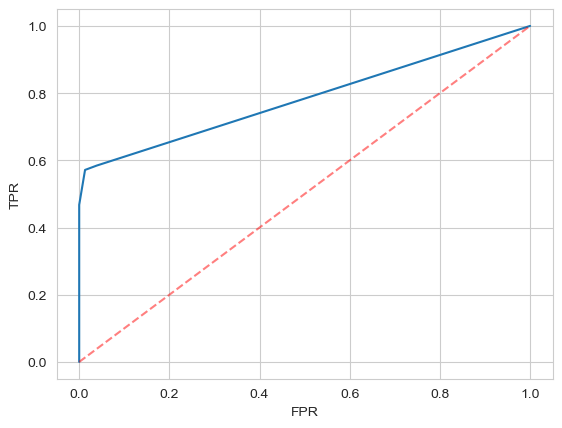

In [61]:
assign_sim(train, test_set, overlap_coefficient)
compute_ROC(test_set)

The Adamic-Adar index accounts for broadly distributed degrees of nodes, logarithmically scaling down the importance of common neighbors with large degrees.

In [64]:
def adamic_adar_index(n, v, w):
    A = 0
    N_v = n.successors[v]
    N_w = n.successors[w]
    for u in N_v.intersection(N_w):
        A += 1 / np.log(len(n.successors[u.uid]))
    return A

AUC = 0.7837746668915498


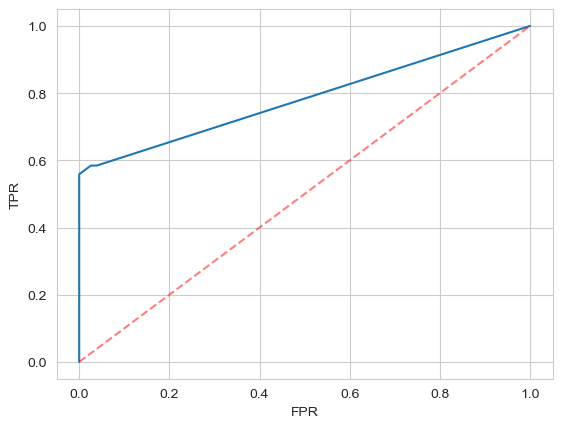

In [65]:
assign_sim(train, test_set, adamic_adar_index)
compute_ROC(test_set)

The cosine similarity uses cosine between the vectors defined by the rows/columns of the adjacency matrix.

In [66]:
def cosine_similarity(network, v, w):    
    if network.degrees()[v] == 0 or network.degrees()[w] == 0:
        return 0
    else:
        A = pp.algorithms.adjacency_matrix(network)
        v_v = A[network.nodes.index[v]].todense().A1
        v_w = A[network.nodes.index[w]].todense().A1
        return np.dot(v_v, v_w)/(np.linalg.norm(v_v)*np.linalg.norm(v_w))

AUC = 0.783184348119413


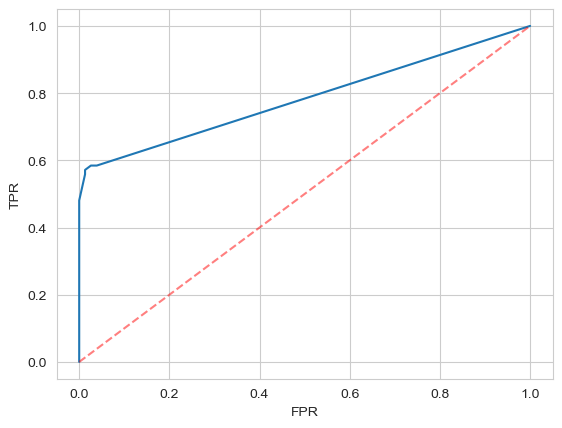

In [67]:
assign_sim(train, test_set, cosine_similarity)
compute_ROC(test_set)

Going beyond neighborhood-based similarity scores, we now test the number of walks up to length k:

In [87]:
def num_walks(n, v, w, **kwargs):
    A = pp.algorithms.adjacency_matrix(n)
    Ak = A
    for i in range(2, kwargs['k']+1):
        Ak += A**kwargs['k']
    return Ak[n.nodes.index[v], n.nodes.index[w]]

AUC = 0.7772811603980434


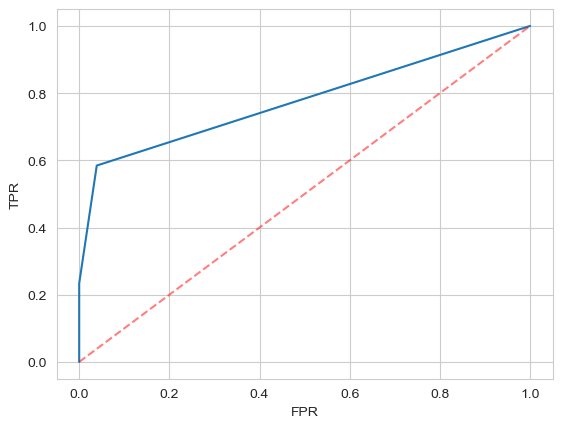

In [78]:
assign_sim(train, test_set, num_walks, k=2)
compute_ROC(test_set)

We see that the maximum walk length $k$ has a strong effect of the predictive power of our classifier:

AUC = 0.69463653229887


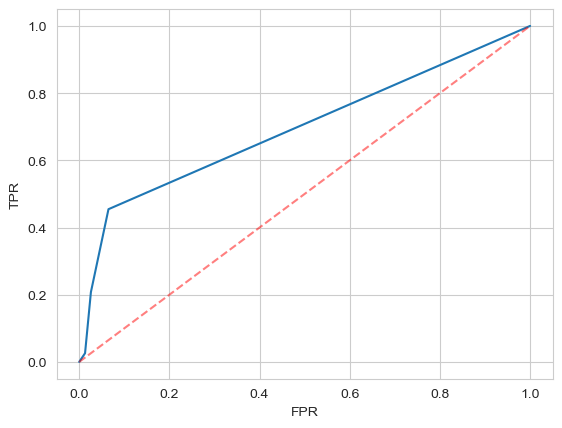

In [82]:
assign_sim(train, test_set, num_walks, k=3)
compute_ROC(test_set)

AUC = 0.7631135098667566


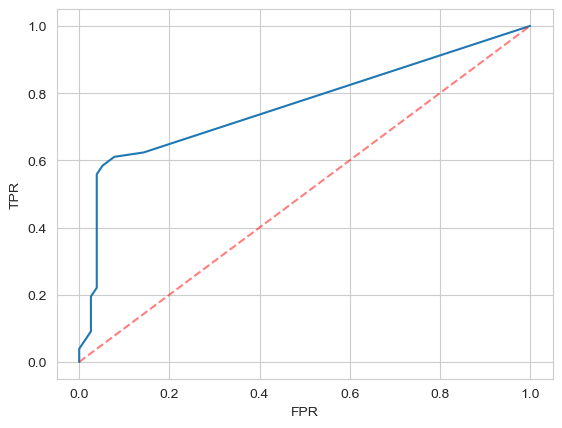

In [83]:
assign_sim(train, test_set, num_walks, k=4)
compute_ROC(test_set)

AUC = 0.6901669758812615


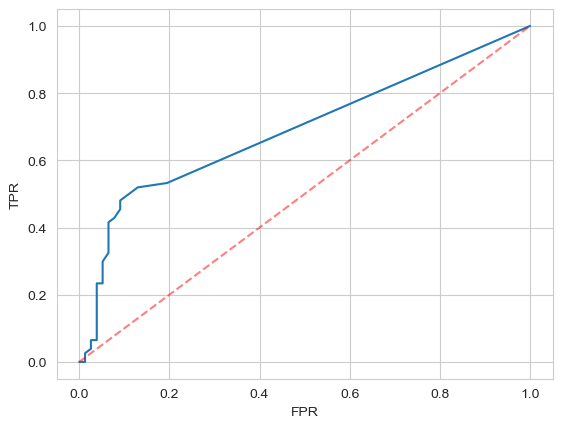

In [84]:
assign_sim(train, test_set, num_walks, k=5)
compute_ROC(test_set)

For our example, the performance decreases if we use a value of $k$ that is too large. This is due to the fact that for such large values, the similarities are dominated by the count of longest paths, which neglects the local structure of the network (e.g. clustering patterns).

AUC = 0.5793557092258391


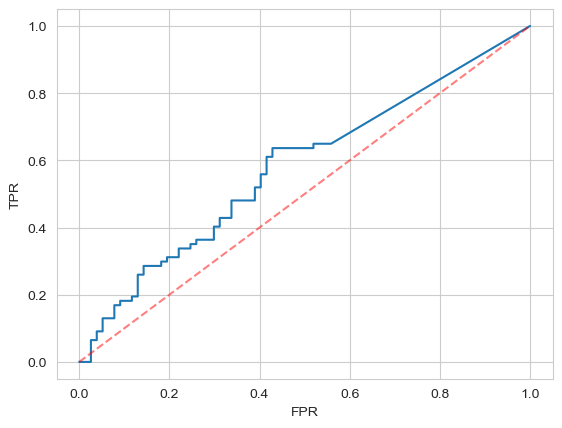

In [89]:
assign_sim(train, test_set, num_walks, k=15)
compute_ROC(test_set)

To fix this issue, we can use the Katz index:

In [107]:
def katz_index(network: pp.Network, v, w, **kwargs):
    A = pp.algorithms.adjacency_matrix(network)
    I = sp.sparse.identity(network.number_of_nodes())
    S = sp.sparse.linalg.inv(I - kwargs['beta'] * A) - I
    return S[network.nodes.index[v], network.nodes.index[w]]

c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


AUC = 0.7380671276775174


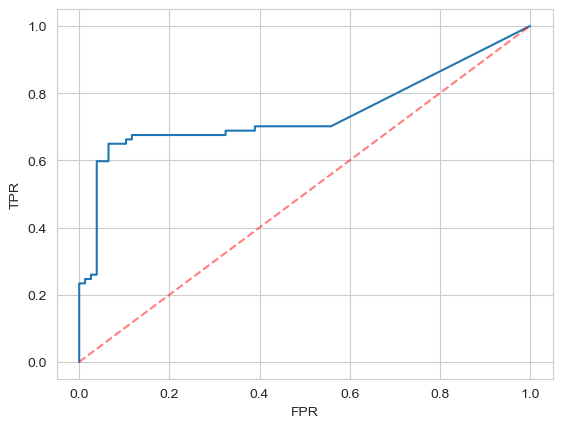

In [100]:
assign_sim(train, test_set, katz_index, beta=0.02)
compute_ROC(test_set)

c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


AUC = 0.6254005734525214


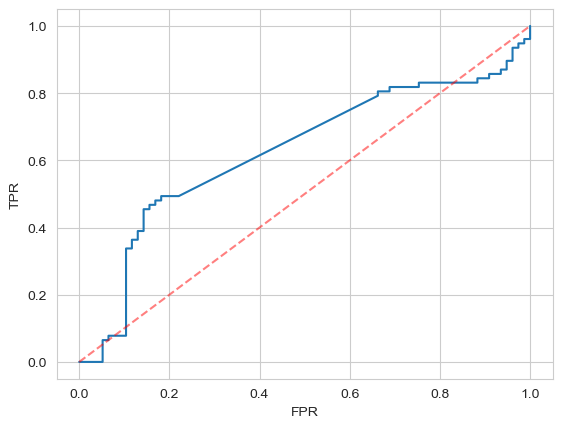

In [101]:
assign_sim(train, test_set, katz_index, beta=0.3)
compute_ROC(test_set)

Let us next test the Leicht-Holme-Newman index, which additionally accounts for the different expected numbers of walks due to heterogeneous degrees in a network.

In [102]:
def LHN_index(network: pp.Network, v, w, **kwargs) -> float:
    A = pp.algorithms.adjacency_matrix(network)
    ev = sp.sparse.linalg.eigs(A, which="LM", k=2, return_eigenvectors=False)
    m = network.number_of_edges()
    eigenvalues_sorted = np.sort(np.absolute(ev))
    lambda_1 = eigenvalues_sorted[0]
    D = sp.sparse.diags(pp.statistics.degree_sequence(network))
    I = sp.sparse.identity(network.number_of_nodes())
    S = 2*m*lambda_1*sp.sparse.linalg.inv(D) * sp.sparse.linalg.inv(I - kwargs['alpha']*A/lambda_1)*sp.sparse.linalg.inv(D)
    return S[network.nodes.index[v], network.nodes.index[w]]


In [104]:
assign_sim(train, test_set, LHN_index, alpha=0.1)
compute_ROC(test_set)

c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


RuntimeError: Factor is exactly singular

In [108]:
def LHN_index(network: pp.Network, v, w, **kwargs) -> float:
    A = pp.algorithms.adjacency_matrix(network)
    ev = sp.sparse.linalg.eigs(A, which="LM", k=2, return_eigenvectors=False)
    m = network.number_of_edges()
    eigenvalues_sorted = np.sort(np.absolute(ev))
    lambda_1 = eigenvalues_sorted[0]
    D = sp.sparse.diags(pp.statistics.degree_sequence(network))
    I = sp.sparse.identity(network.number_of_nodes())
    S = 2*m*lambda_1*sp.sparse.linalg.inv(D) * sp.sparse.linalg.inv(I - kwargs['alpha']*A/lambda_1)*sp.sparse.linalg.inv(D)
    if v in network.nodes and w in network.nodes:
        return S[network.nodes.index[v], network.nodes.index[w]]
    else:
        return 0


c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


AUC = 0.609714960364311


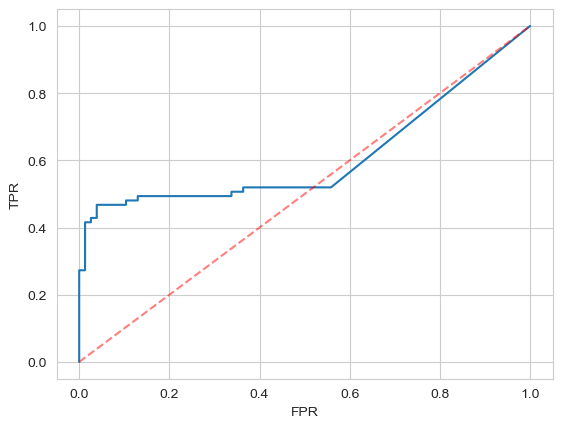

In [111]:
assign_sim(pp.algorithms.largest_connected_component(train), test_set, LHN_index, alpha=0.02)
compute_ROC(test_set)

c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


AUC = 0.6095462978579862


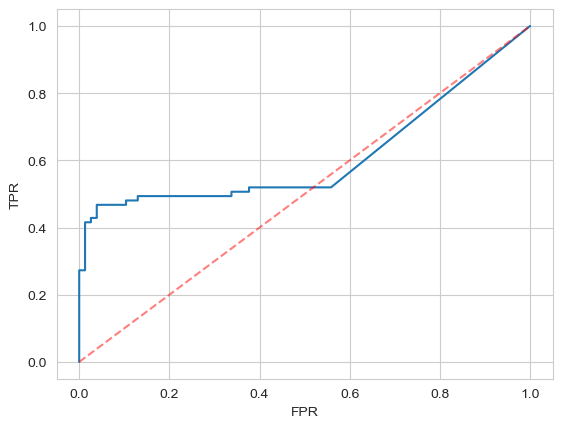

In [112]:
assign_sim(pp.algorithms.largest_connected_component(train), test_set, LHN_index, alpha=0.2)
compute_ROC(test_set)